# **Tarea 2**
## Machine Learning
### Omar Guerra - Estudiante de Ingeniería. Civil Matemática
#### Universidad de Valparaíso



---



Remarcamos que este código está basado en la implementación vista en clases, diseñado por el Profesor Alejandro Pereira, para los primeros modelos: regresión logística y svm.
Naïve Bayes, LDA y QDA fueron obtenidos desde la web.
Esta tarea se realizó en conjunto con Kathryn Barraza.

##Índice##

*   Introduccón
*   Objetivos
*   Implementación
    *   Variables a utilizar
    *   Separación de datos
    *   Modelos
*   Análisis
*   Conclusiones

##Introducción##

En la búsqueda de estudiar distintos modelos de aprendizaje supervisado, se realizará una implementación en python de Regresión Logística, SVM, Naïve Bayes, LDA y QDA. En esta realización se utilizará una data extraída de Kaggle en donde nuestra variable respuesta hace referencia a las chances de tener un ataque cardiaco.

##Objetivos##
* Comparar regresión logística, SVM, Naive Bayes, LDA y QDA.
* Usar métricas de desempeño.
* Exponer comentarios y análisis.

##Implementación##

In [63]:
#Importamos las librerias necesarias
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.preprocessing import StandardScaler

In [64]:
#Importamos los datos
from google.colab import drive
drive.mount('/content/drive')
url='/content/drive/MyDrive/2023/sem 1/Machine/data.csv'
df= pd.read_csv(url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
#Mostramos los primeros datos de todo nuestro conjunto
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [66]:
#Aquí arreglamos ciertas cosas con respecto a la data: renombramos, borramos lo que tiene datos perdidos y vemos al final con cuantos datos nos quedamos.
df.rename(columns = {'num       ': 'attack'}, inplace = True)
df.replace("?", np.nan, inplace = True)
df.drop(columns = ['slope', 'ca', 'thal'], inplace = True)
df.dropna(inplace= True)
df.shape

(261, 11)

### Variables que vamos a usar

    age: age in years
    sex: sex (1 = male; 0 = female)
    cp: chest pain type
    – 1: typical angina
    – 2: atypical angina
    – 3: non-anginal pain
    – 4: asymptomatic
    trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    chol: serum cholesterol in mg/dl
    fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    restecg: resting electrocardiographic results
    – 0: normal
    – 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    – 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
    thalach: maximum heart rate achieved
    exang: exercise-induced angina (1 = yes; 0 = no)
    oldpeak: ST depression induced by exercise relative to rest

## Test - Train split

Separamos nuestra muestra en datos de entrenamiento y datos de test. Tomamos la separación para los cinco modelos con el mismo tamaño de test 0.3 y semilla 125. Esto es para guardar consistencia entre modelos

In [5]:
#Realizamos una división de los datos en conjuntos de entrenamiento y prueba, en donde el 30% de estos serán utilizados para prueba
df_train, df_test = train_test_split(df, test_size=0.3, random_state=random_seed, stratify=df['attack'])
random_seed = 125

#Imprimimos los tamaños de nuestros conjuntos de entrenamiento y test, además de exhibir los porcentajes
## de de ataques cardiacos en nuestra división de datos

print(df_train.shape) #tamaño de nuestros datos de entrenamiento
print(df_test.shape) #tamaño de nuestros datos de test

print("\nPercentages of heart attacks in Train data:\n", df_train['attack'].value_counts(normalize=True))
print("\nPercentages of heart attacks in Test data:\n", df_test['attack'].value_counts(normalize=True))

(182, 11)
(79, 11)

Percentages of heart attacks in Train data:
 0    0.626374
1    0.373626
Name: attack, dtype: float64

Percentages of heart attacks in Test data:
 0    0.620253
1    0.379747
Name: attack, dtype: float64


In [67]:
#Separamos a las variables en dos grupos, numéricas y categóricas
#Estandarizamos las variables numéricas para trabajar con el modelo de Regresión logística
## pues al intentar hacerlo sin reescalamiento había un aviso de problemas de convergencia, por lo que mejor estandarizamos en este caso

numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = list(set(df.columns) - set(numeric_cols) - {'attack'})
cat_cols.sort()

print("Numerical var:", numeric_cols)
print("\nCategorical var:", cat_cols)

scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

#Esta función escala las características numéricas, combina las características categóricas y numéricas en una matriz de características "X", y devuelve
## tanto la matriz de características "X" como la matriz de etiquetas "y".


def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['attack']
    return X, y


X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

Numerical var: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

Categorical var: ['cp', 'exang', 'fbs', 'restecg', 'sex']


##Regresión Logística##
La regresión logística es un modelo de regresión supervisado para predecir el valor de uno de esos factores basándose en el otro. Este se basa en encontrar las relaciones entre dos factores de datos.




In [68]:
#Ajustamos el modelo de regresión logística

log = LogisticRegression()

log.fit(X, y)

LogisticRegression()

In [69]:
#Evaluamos el modelo

X_test_log, y_test_log = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)
y_score_log = log.decision_function(X_test_log)

Text(0.5, 1.0, 'Curva ROC contrastada con Random Guessing')

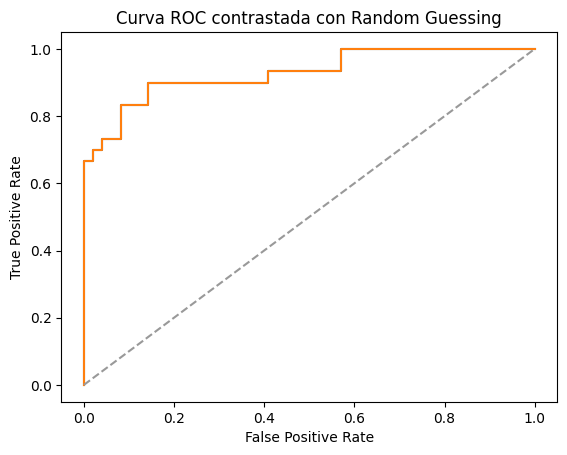

In [70]:
#Visualizamos la curva ROC y calcula el AUC (celda de abajo) para nuestro modelo

fpr_log, tpr_log, _ = sk_metrics.roc_curve(y_test_log, y_score_log, pos_label= log.classes_[1])
roc_display_log = sk_metrics.RocCurveDisplay(fpr= fpr_log, tpr= tpr_log).plot()
roc_auc_log = sk_metrics.auc(fpr_log,tpr_log)
plt.plot(fpr_log, tpr_log, label="ROC fold (area=%0.2f)"%(roc_auc_log))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Curva ROC contrastada con Random Guessing')

Es claro que nuestro modelo de regresión ajusta mucho mejor que la curva segmantada gris, la cual es análoga al lanzar una moneda equilibrada.

Nuestro modelo se ajusta más al 1, por ende nos inclinamos en él en vez del random guessing.

In [71]:
round(roc_auc_log,3) # utilizaremos este comando para redondear a 3 decimales

0.929

El valor del AUC, carga un procentaje de 0.93%.

Sabemos que el AUC indica que tan bueno es nuestro modelo en función de cuanto más cerca esté del 1.

El modelo de regresión puede considerarse bueno en base a este AUC.

# **SVM**
El modelo SVM se puede definir como un conjunto de algoritmos de aprendizaje supervisado. Por ejemplo, dado un conjunto de muestras de entrenamiento, podemos etiquetar las clases y entrenar con ellas un modelo SVM, que nos servirá para predecir la clase de una nueva muestra.

---



In [72]:
#Importamos las librerías de utilidad

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

In [73]:
#Separamos la columna "attack" como la serie de etiquetas "y", y creamos una matriz de características "X" sin la columna "attack"

y = df["attack"]
X = df.drop('attack',axis=1)

#Al igual que antes, realizamos una partición de nuestros datos en un conjunto de entrenamiento y otro
## conjunto de prueba en el cual el 20% de los datos serán utilizados para testear

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.20, random_state = 123, stratify=df['attack'])

In [74]:
#Ajustamos nuestro modelo de SVM

svc =  svm.SVC(kernel='linear', C=1)
svc.fit(X_train_svm, y_train_svm)

#Predecimos las eqtiquetas correspondientes a los datos de prueba

svc_predicted = svc.predict(X_test_svm)

#Exhibimos la matriz de confusión

svc_conf_matrix = sk_metrics.confusion_matrix(y_test_svm, svc_predicted)

#Calculamos la precisión del modelo de SVM al comparar las etiquetas verdaderas con las etiquetas predichas

svc_acc_score = sk_metrics.accuracy_score(y_test_svm, svc_predicted)

print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:", svc_acc_score*100,'\n')
print(sk_metrics.classification_report(y_test_svm, svc_predicted))



confussion matrix
[[28  5]
 [ 6 14]]


Accuracy of Support Vector Classifier: 79.24528301886792 

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        33
           1       0.74      0.70      0.72        20

    accuracy                           0.79        53
   macro avg       0.78      0.77      0.78        53
weighted avg       0.79      0.79      0.79        53



En esta instancia pordemos ver algunos valores de métricas de desempeño como por ejemplo el F1. Donde de igual manera podemos decir que nuestro modelo está ajustando relativamente bien ya que es medianamente cercana a 1; sin contemplar gráficas aún.

In [75]:
#Aplicamos un SVM previamente entrenado "svc" para calcular las puntuaciones de decisión para los datos de prueba

y_score_svm = svc.decision_function(X_test_svm.to_numpy())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Curva ROC SVM contrastada con Random Guessing')

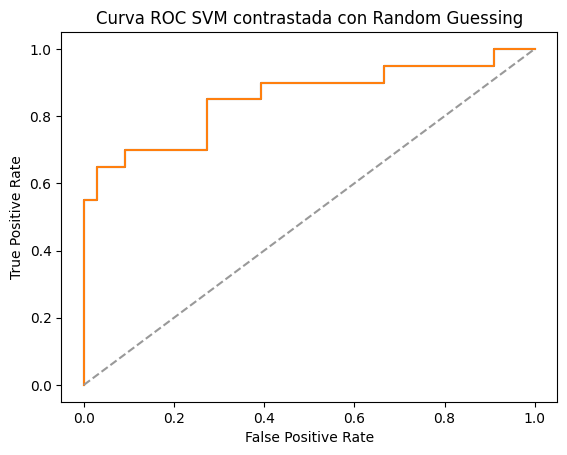

In [76]:
#Vizualizamos la curva ROC y Calculamos el AUC

fpr_svm, tpr_svm, _ = sk_metrics.roc_curve(y_test_svm, y_score_svm)
roc_display_svm = sk_metrics.RocCurveDisplay(fpr= fpr_svm, tpr= tpr_svm).plot()
roc_auc_svm=sk_metrics.auc(fpr_svm,tpr_svm)
plt.plot(fpr_svm, tpr_svm, label="ROC fold (area=%0.2f)"%(roc_auc_svm))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Curva ROC SVM contrastada con Random Guessing')


In [77]:
round(roc_auc_svm,3)

0.853

Similarmente al modelo anterior, este está ajustando bien al 85%, pero es menor que el modelo anterior.

# **Naive Bayes**
Los modelos de Naive Bayes se basan en una técnica de clasificación estadística llamada “teorema de Bayes”. Son llamados algoritmos “Naive”, o “Inocentes” en español, pues en ellos se asume que las variables predictoras son independientes entre sí, por lo tanto proporcionan una manera fácil de construir modelos con un comportamiento muy bueno debido a su simplicidad.

---



In [78]:
#Importamos las librerias necesarias

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)


In [79]:
#Como ya lo hemos realizado en los modelos anteriores, hacemos nuestra división de los datos en
## entrenamiento y 30% de estos para testear

y = df["attack"]
X = df.drop('attack',axis=1)

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.3, random_state=125)

In [80]:
#Creamos y ajustamos el modelo de clasificador de Naive Bayes Gaussiano

gnb = GaussianNB()

gnb.fit(X_train_nb, y_train_nb);

In [81]:
#Realizamos predicciones en los datos de test y calculamos sus metricas de desempeño

y_pred_nb = gnb.fit(X_train_nb, y_train_nb).predict(X_test_nb)

accuray_nb = accuracy_score(y_pred_nb, y_test_nb)
f1_nb = f1_score(y_pred_nb, y_test_nb, average="weighted")

print("Accuracy:", round(accuray_nb,3))
print("F1 Score:", round(f1_nb,3))

Accuracy: 0.759
F1 Score: 0.754


Este modelo GNB según sus métricas de desmpeño, está ajustando al 76%, que podría seguir bueno, pero hasta ahora es el más bajo de todos.

In [82]:
#Predecimos las probabilidades de las etiquetas para el conjunto de datos de test

y_gnb_score = gnb.predict_proba(X_test_nb)

Text(0.5, 1.0, 'Curva ROC GNB contrastada con Random Guessing')

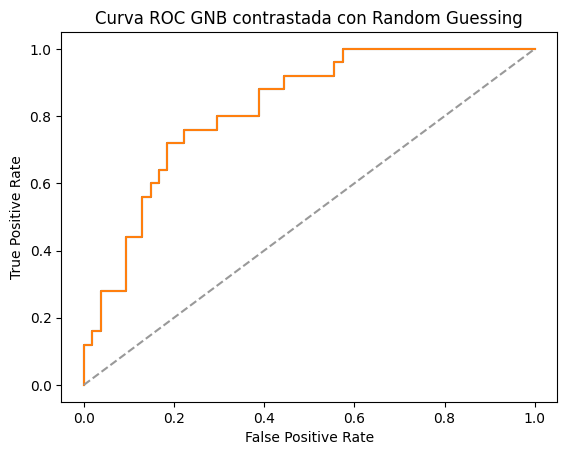

In [83]:
#Vizualizamos la curva ROC y Calculamos el AUC

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test_nb, y_gnb_score[:, 1])
roc_display_gnb = sk_metrics.RocCurveDisplay(fpr= fpr_gnb, tpr= tpr_gnb).plot()
roc_auc_gnb=sk_metrics.auc(fpr_gnb,tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, label="ROC fold (area=%0.2f)"%(roc_auc_gnb))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Curva ROC GNB contrastada con Random Guessing')


In [84]:
round(roc_auc_gnb,3)

0.822

El AUC de este modelo está ajustando al 82%, lo cual se coloca sólo un poco detrás del SVM.

# **LDA**
El análisis discriminante linear (LDA) es un algoritmo de aprendizaje supervisado que se utiliza para tareas de clasificación en Machine Learning. Es una técnica utilizada para encontrar una combinación lineal de características que mejor separe las clases en un conjunto de datos.

---



In [85]:
#Importamos librería

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [86]:
#Nuevamente hacemos nuestra división de los datos en entrenamiento y 30% de estos para testear

y = df["attack"]
X = df.drop('attack',axis=1)

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X, y, test_size=0.3, random_state=125)

In [87]:
#Creamos y ajustamos nuestro modelo LDA

lda = LDA()

lda.fit(X_train_lda, y_train_lda);

In [88]:
#Al igual que antes predecimos las probabilidades de las etiquetas para el conjunto de datos de test

y_lda_score = lda.predict_proba(X_test_lda)

Text(0.5, 1.0, 'Curva ROC LDA constrastada con Random Guessing')

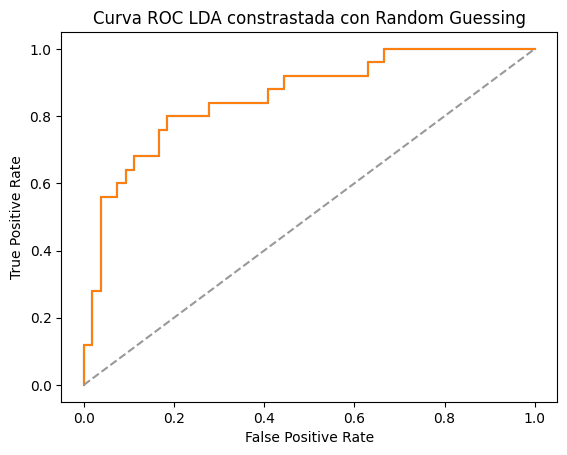

In [89]:
#Vizualizamos curva y calculamos AUC del modelo

pr_lda, tpr_lda, thresholds_lda = roc_curve(y_test_lda, y_lda_score[:, 1])
roc_display_lda = sk_metrics.RocCurveDisplay(fpr= fpr_lda, tpr= tpr_lda).plot()
roc_auc_lda =sk_metrics.auc(fpr_lda,tpr_lda)
plt.plot(fpr_lda, tpr_lda, label="ROC fold (area=%0.2f)"%(roc_auc_lda))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Curva ROC LDA constrastada con Random Guessing')

In [90]:
round(roc_auc_lda,3)

0.858

Según el AUC de este modelo LDA se coloca al mismo nivel de buen ajuste que el SVM.

# **QDA**

---


Este método es similar al LDA y también asume que las observaciones de cada clase se distribuyen normalmente, pero no asume que cada clase comparta la misma matriz de covarianza. En cambio, QDA supone que cada clase tiene su propia matriz de covarianza.

In [91]:
#Importamos librería necesaria

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [92]:
#Hacemos nuestra división de los datos en entrenamiento y 30% de estos para testear

y = df["attack"]
X = df.drop('attack',axis=1)

X_train_qda, X_test_qda, y_train_qda, y_test_qda = train_test_split(X, y, test_size=0.3, random_state=125)

In [93]:
#Creamos y ajustamos el modelo QDA

qda = QDA()
qda.fit(X_train_qda, y_train_qda)

QuadraticDiscriminantAnalysis()

In [94]:
#Al igual que antes predecimos las probabilidades de las etiquetas para el conjunto de datos de test

y_score_qda = qda.predict_proba(X_test_qda)

Text(0.5, 1.0, 'Curva ROC LDA contrastada con Random Guessing')

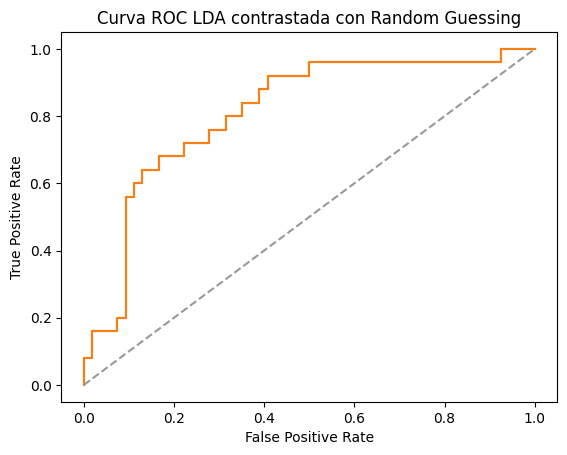

In [95]:
#Vizualizamos curva y calculamos AUC del modelo

fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test_qda, y_score_qda[:, 1])
roc_display_qda = sk_metrics.RocCurveDisplay(fpr= fpr_qda, tpr= tpr_qda).plot()
roc_auc_qda = sk_metrics.auc(fpr_qda,tpr_qda)
plt.plot(fpr_qda, tpr_qda, label="ROC fold (area=%0.2f)"%(roc_auc_qda))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Curva ROC LDA contrastada con Random Guessing')

In [96]:
round(roc_auc_qda,3)

0.81

Notamos que el AUC de este modelo está ajustando al 81%, lo cual lo coloca detrás del GNB

# **Análisis**

In [97]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

#En esta celda se resumen y se van a contrastar todos los modelos utilizados para nuestros datos en base a las métricas de desempeño usuales,
## en la siguiente celda se construirá una tabla para una vizualización sencilla de estas métricas.

y_pred_log = log.fit(X, y).predict(X_test_log)
y_pred_svm = svc.fit(X_train_svm, y_train_svm).predict(X_test_svm)
y_pred_nb = gnb.fit(X_train_nb, y_train_nb).predict(X_test_nb)
y_pred_lda = lda.fit(X_train_lda, y_train_lda).predict(X_test_lda)
y_pred_qda = qda.fit(X_train_qda, y_train_qda).predict(X_test_qda)

accuray_log = accuracy_score(y_pred_log, y_test_log)
f1_log = f1_score(y_pred_log, y_test_log, average="weighted")
accuray_svm = accuracy_score(y_pred_svm, y_test_svm)
f1_svm = f1_score(y_pred_svm, y_test_svm, average="weighted")
accuray_nb = accuracy_score(y_pred_nb, y_test_nb)
f1_nb = f1_score(y_pred_nb, y_test_nb, average="weighted")
accuray_lda = accuracy_score(y_pred_lda, y_test_lda)
f1_lda = f1_score(y_pred_lda, y_test_lda, average="weighted")
accuray_qda = accuracy_score(y_pred_qda, y_test_qda)
f1_qda = f1_score(y_pred_qda, y_test_qda, average="weighted")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Para realizar una comparación más sencilla a la vista, realizamos una tabla donde resumiremos las medidas de desmepeño de los modelos.

In [98]:
# Tabla de comparaciones

desem = [ ["LG", round(roc_auc_log,3), round(accuray_log,3), round(f1_log,3)],
     ["SVM", round(roc_auc_svm,3), round(accuray_svm,3), round(f1_svm,3)],
     ["GNB", round(roc_auc_gnb,3), round(accuray_nb,3), round(f1_nb,3)],
     ["LDA", round(roc_auc_lda,3), round(accuray_lda,3), round(f1_lda,3)],
     ["QDA", round(roc_auc_qda,3), round(accuray_qda,3), round(f1_qda,3)]]

print ("{:<8}  {:<10}   {:<20}  {:<30}".format('Modelo','AUC','Accuracy','F1'))

for v in desem:
    Modelo, AUC, Accuracy, F1= v
    print ("{:<8} {:<10}   {:<20}  {:<30}".format( Modelo, AUC, Accuracy, F1))

Modelo    AUC          Accuracy              F1                            
LG       0.929        0.709                 0.705                         
SVM      0.853        0.792                 0.794                         
GNB      0.822        0.759                 0.754                         
LDA      0.858        0.797                 0.797                         
QDA      0.81         0.759                 0.754                         


##Conclusiones##

Si nos basamos en AUC nuestros modelos ordenados de mejor a peor son: LG, LDA, SVM, GNB y QDA.

Si nos basamos en Accuracy el orden es: LDA, SVM, QDA, GNB y LG.

Si nos basamos en F1 los ordenes serán: LDA, SVM, QDA, GNB y LG.

Es preciso notar que dado el tamaño del test_train y según la semilla que escojamos, nuestras métricas de desempeño pueden variar e indicar que no necesariamente se preserve el orden de los mejores modelos.

Además para finalizar debemos remarcar que no es correcto preferir una métrica de desempeño sobre otra, sólo son ilustrativas entre sí, i.e no hacen alusión a decir que una métrica es mejor que otra para decidir en cuál de ellas basarse para la elección de nuestro modelo.